In [1]:
import argparse
import logging
import os
import shutil
from datetime import datetime, timedelta
from typing import List

import torch
from omegaconf import OmegaConf
from torch.utils.data import ConcatDataset, DataLoader
from tqdm import tqdm

from models.MiDas import MidasNet
from models.TernausNet import UNet16 

from datasets import BaseDepthDataset, DatasetMode, get_dataset
from datasets.mixed_sampler import MixedBatchSampler
from trainers.mytrainer import NetTrainer
from util.config_util import (
    find_value_in_omegaconf,
    recursive_load_config,
)
from util.depth_transform import (
    DepthNormalizerBase,
    get_depth_normalizer,
)
from util.logging_util import(
  config_logging
)

c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

class args:
    def __init__(self) -> None:
        self.config = "config/test.yaml"
        self.resume_run = './test/checkpoint/latest'
        self.output_dir = "./" # "/content/drive/MyDrive/magisterka"
        self.base_data_dir = 'C:/Users/micha/Downloads/nyu_v2-20240826T235024Z-001'
        self.add_datetime_prefix = False
        self.exit_after = -1
        self.no_cuda = False

args = args()

resume_run = args.resume_run
output_dir = args.output_dir
base_data_dir = (
    args.base_data_dir
    if args.base_data_dir is not None
    else os.environ["BASE_DATA_DIR"]
)

t_start = datetime.now()

# Resume previous run
if resume_run is not None:
    print(f"Resume run: {resume_run}")
    out_dir_run = os.path.dirname(os.path.dirname(resume_run))
    job_name = os.path.basename(out_dir_run)
    # Resume config file
    cfg = OmegaConf.load(os.path.join(out_dir_run, "config.yaml"))
else:
    # Run from start
    cfg = recursive_load_config(args.config)
    # Full job name
    pure_job_name = os.path.basename(args.config).split(".")[0]
    # Add time prefix
    if args.add_datetime_prefix:
        job_name = f"{t_start.strftime('%y_%m_%d-%H_%M_%S')}-{pure_job_name}"
    else:
        job_name = pure_job_name
    # Output dir
    if output_dir is not None:
        out_dir_run = os.path.join(output_dir, job_name)
    else:
        out_dir_run = os.path.join("./output", job_name)
    os.makedirs(out_dir_run, exist_ok=False)

cfg_data = cfg.dataset

# Other directories
out_dir_ckpt = os.path.join(out_dir_run, "checkpoint")
if not os.path.exists(out_dir_ckpt):
    os.makedirs(out_dir_ckpt)
out_dir_tr = os.path.join(out_dir_run, "training_record")
if not os.path.exists(out_dir_tr):
    os.makedirs(out_dir_tr)
out_dir_eval = os.path.join(out_dir_run, "evaluation_record")
if not os.path.exists(out_dir_eval):
    os.makedirs(out_dir_eval)
# -------------------- Logging settings --------------------
config_logging(cfg.logging, out_dir=out_dir_run)
logging.debug(f"config: {cfg}")
# -------------------- Device --------------------
cuda_avail = torch.cuda.is_available() and not args.no_cuda
device = torch.device("cuda" if cuda_avail else "cpu")
logging.info(f"device = {device}")
# -------------------- Snapshot of code and config --------------------
if resume_run is None:
    _output_path = os.path.join(out_dir_run, "config.yaml")
    with open(_output_path, "w+") as f:
        OmegaConf.save(config=cfg, f=f)
    logging.info(f"Config saved to {_output_path}")
    # Copy and tar code on the first run
    _temp_code_dir = os.path.join(out_dir_run, "code_tar")
    _code_snapshot_path = os.path.join(out_dir_run, "code_snapshot.tar")
    os.system(
        f"rsync --relative -arhvz --quiet --filter=':- .gitignore' --exclude '.git' . '{_temp_code_dir}'"
    )
    os.system(f"tar -cf {_code_snapshot_path} {_temp_code_dir}")
    os.system(f"rm -rf {_temp_code_dir}")
    logging.info(f"Code snapshot saved to: {_code_snapshot_path}")

Resume run: ./test/checkpoint/latest
 2024-08-27 05:27:44,105 - INFO -406959964.py - <module> >> device = cuda


In [4]:
# -------------------- Data --------------------
loader_seed = cfg.dataloader.seed
if loader_seed is None:
    loader_generator = None
else:
    loader_generator = torch.Generator().manual_seed(loader_seed)
# Training dataset
depth_transform: DepthNormalizerBase = get_depth_normalizer(
    cfg_normalizer=cfg.depth_normalization
)
train_dataset: BaseDepthDataset = get_dataset(
    cfg_data.train,
    base_data_dir=base_data_dir,
    mode=DatasetMode.TRAIN,
    augmentation_args=cfg.augmentation_args,
    depth_transform=depth_transform,
)
logging.debug("Augmentation: ", cfg.augmentation_args)
if "mixed" == cfg_data.train.name:
    dataset_ls = train_dataset
    assert len(cfg_data.train.prob_ls) == len(
        dataset_ls
    ), "Lengths don't match: `prob_ls` and `dataset_list`"
    concat_dataset = ConcatDataset(dataset_ls)
    mixed_sampler = MixedBatchSampler(
        src_dataset_ls=dataset_ls,
        batch_size=cfg.dataloader.train_batch_size,
        drop_last=True,
        prob=cfg_data.train.prob_ls,
        shuffle=True,
        generator=loader_generator,
    )
    train_loader = DataLoader(
        concat_dataset,
        batch_sampler=mixed_sampler,
        num_workers=cfg.dataloader.num_workers,
    )
else:
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=cfg.dataloader.train_batch_size,
        num_workers=cfg.dataloader.num_workers,
        shuffle=True,
        generator=loader_generator,
    )
# Validation dataset
val_dataset: BaseDepthDataset = get_dataset(
    cfg_data.val,
    base_data_dir=base_data_dir,
    mode=DatasetMode.TRAIN,
    depth_transform=depth_transform,
)
if "mixed" == cfg_data.val.name:
    dataset_ls = val_dataset
    assert len(cfg_data.val.prob_ls) == len(
        dataset_ls
    ), "Lengths don't match: `prob_ls` and `dataset_list`"
    concat_dataset = ConcatDataset(dataset_ls)
    mixed_sampler = MixedBatchSampler(
        src_dataset_ls=dataset_ls,
        batch_size=cfg.dataloader.val_batch_size,
        drop_last=True,
        prob=cfg_data.val.prob_ls,
        shuffle=False,
        generator=loader_generator,
    )
    val_loader = DataLoader(
        concat_dataset,
        batch_sampler=mixed_sampler,
        num_workers=cfg.dataloader.num_workers,
    )
else:
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=cfg.dataloader.val_batch_size,
        num_workers=cfg.dataloader.num_workers,
        shuffle=False,
        generator=loader_generator,
    )
# Test dataset
test_loaders: List[DataLoader] = []
for _test_dic in cfg_data.test:
    _test_dataset = get_dataset(
        _test_dic,
        base_data_dir=base_data_dir,
        mode=DatasetMode.TRAIN,
        depth_transform=depth_transform,
    )
    _test_loader = DataLoader(
        dataset=_test_dataset,
        batch_size=cfg.dataloader.test_batch_size,
        shuffle=False,
        num_workers=cfg.dataloader.num_workers,
    )
    test_loaders.append(_test_loader)
    
dataloaders = {
    'train': train_loader,
    'vals': val_loader,
    'tests': test_loaders
}

# -------------------- Model --------------------
if cfg.model.name == 'TernausNet':
    model = UNet16(pretrained=True, is_deconv=True)
elif cfg.model.name == 'MiDas':
  model = MidasNet(backbone=cfg.model.backbone)
else:
  raise NotImplementedError 

c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


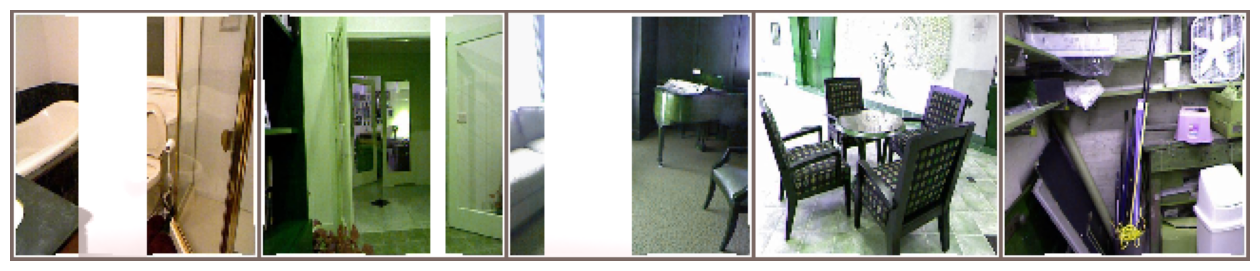

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imgshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.48012177, 0.41071795, 0.39187136])
    std = np.array([0.28875302, 0.29516797, 0.30792887])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# for samples, _ in iter(dataloaders['train']):
batch = next(iter(dataloaders['train']))
samples = batch['rgb_img']
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples)
imgshow(grid_imgs)

In [6]:
# -------------------- Trainer --------------------
# Exit time
if args.exit_after > 0:
    t_end = t_start + timedelta(minutes=args.exit_after)
    logging.info(f"Will exit at {t_end}")
else:
    t_end = None
logging.debug(f"Trainer: treiner_nets")
trainer = NetTrainer(
    cfg=cfg,
    model=model,
    train_dataloader=train_loader,
    device=device,
    out_dir_ckpt=out_dir_ckpt,
    out_dir_tr=out_dir_tr,
    out_dir_eval=out_dir_eval,
    val_dataloader=val_loader,
    test_dataloaders=test_loaders,
)

In [7]:
# -------------------- Checkpoint --------------------
if resume_run is not None:
    trainer.load_checkpoint(
        resume_run, load_trainer_state=True, resume_lr_scheduler=True
    )

 2024-08-27 05:28:00,314 - INFO -mytrainer.py - load_checkpoint >> Loading checkpoint from: ./test/checkpoint/latest
 2024-08-27 05:28:02,432 - INFO -mytrainer.py - load_checkpoint >> Net parameters are loaded from ./test/checkpoint/latest\net.pth
 2024-08-27 05:28:03,364 - INFO -mytrainer.py - load_checkpoint >> optimizer state is loaded from ./test/checkpoint/latest
 2024-08-27 05:28:03,366 - INFO -mytrainer.py - load_checkpoint >> LR scheduler state is loaded from ./test/checkpoint/latest
 2024-08-27 05:28:03,452 - INFO -mytrainer.py - load_checkpoint >> Checkpoint loaded from: ./test/checkpoint/latest. Resume from iteration 12 (epoch 2)


In [8]:
# -------------------- Training & Evaluation Loop --------------------
try:
    trainer.train(t_end=t_end)
except Exception as e:
    logging.exception(e)

 2024-08-27 05:28:03,477 - INFO -mytrainer.py - train >> Start training


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 2/8 [00:24<01:02, 10.47s/it]

 2024-08-27 05:28:30,160 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test\checkpoint\latest
 2024-08-27 05:28:30,910 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test\checkpoint\latest\net.pth
 2024-08-27 05:28:32,019 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test\checkpoint\latest\trainer.ckpt


 62%|██████▎   | 5/8 [00:33<00:13,  4.46s/it]

 2024-08-27 05:28:38,855 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test\checkpoint\latest


 62%|██████▎   | 5/8 [00:35<00:21,  7.06s/it]

 2024-08-27 05:28:38,865 - ERROR -1570283203.py - <module> >> [WinError 5] Odmowa dostępu: './test\\checkpoint\\latest' -> './test\\checkpoint\\_old_latest'
Traceback (most recent call last):
  File "C:\Users\micha\AppData\Local\Temp\ipykernel_7292\1570283203.py", line 3, in <module>
    trainer.train(t_end=t_end)
  File "c:\Users\micha\OneDrive - SGH\Estymacja-glebi-na-podstawie-pojedynczego-zdejcia\trainers\mytrainer.py", line 209, in train
    self._train_step_callback()
  File "c:\Users\micha\OneDrive - SGH\Estymacja-glebi-na-podstawie-pojedynczego-zdejcia\trainers\mytrainer.py", line 255, in _train_step_callback
    self.save_checkpoint(ckpt_name="latest", save_train_state=True)
  File "c:\Users\micha\OneDrive - SGH\Estymacja-glebi-na-podstawie-pojedynczego-zdejcia\trainers\mytrainer.py", line 362, in save_checkpoint
    os.rename(ckpt_dir, temp_ckpt_dir)
PermissionError: [WinError 5] Odmowa dostępu: './test\\checkpoint\\latest' -> './test\\checkpoint\\_old_latest'


In [9]:
import pandas as pd
import torch

def rmse_log(output, target, valid_mask=None):
    diff = torch.log(output) - torch.log(target)
    if valid_mask is not None:
        diff[~valid_mask] = 0
        n = valid_mask.sum((-1, -2))
    else:
        n = output.shape[-1] * output.shape[-2]
    diff2 = torch.pow(diff, 2)
    mse = torch.sum(diff2, (-1, -2)) / n  # [B]
    rmse = torch.sqrt(mse)
    return rmse.mean()


def log10(output, target, valid_mask=None):
    if valid_mask is not None:
        diff = torch.abs(
            torch.log10(output[valid_mask]) - torch.log10(target[valid_mask])
        )
    else:
        diff = torch.abs(torch.log10(output) - torch.log10(target))
    return diff.mean()

def silog_rmse(depth_pred, depth_gt, valid_mask=None):
    diff = torch.log(depth_pred) - torch.log(depth_gt)
    if valid_mask is not None:
        diff[~valid_mask] = 0
        n = valid_mask.sum((-1, -2))
    else:
        n = depth_gt.shape[-2] * depth_gt.shape[-1]

    diff2 = torch.pow(diff, 2)

    first_term = torch.sum(diff2, (-1, -2)) / n
    second_term = torch.pow(torch.sum(diff, (-1, -2)), 2) / (n**2)
    loss = torch.sqrt(torch.mean(first_term - second_term)) * 100
    return loss